## Qiskit Basics

To begin, we'll need to import the following qiskit libraries, along with numpy, cmath, and an additional module I've written called qis401 that contains a wrapper function for simulating quantum circuits. (You can find <code>qis401.py</code> in the course documents on Canvas; be sure to move this file to your working directory.)  

In [1]:
import numpy as np, cmath
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, assemble, Aer
from qiskit.quantum_info import Statevector
from qiskit.visualization import array_to_latex, state_visualization
from qiskit.visualization import plot_bloch_multivector, plot_histogram, plot_state_city 
import qis401 # written for CS 401 

### Creating and Simulating Quantum Circuits

The below code constructs a 1-qubit quantum circuit that performs Hadamard gate, then X gate, then Z gate.

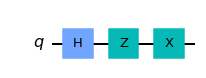

In [2]:
circ = QuantumCircuit(1)  # pass in 1 to specify circuit has 1 qubit
circ.h(0)                 # pass in index of qubit you want to perform the gate on (0-indexed)
circ.z(0)
circ.x(0)
circ.draw('mpl')          # displays circuit as a diagram

Once we've constructed a circuit object, we can then use the <code>qis401</code> function <code>simulate_circuit(circ)</code> to return a "result object" that encapsulates various meta data related to the final quantum state of the circuit, along with information about its simulation (i.e., "simulating" the circuit in fact repeatedly measures the final state and aggregates the results). You can look at <code>qis401.py</code> to see what qiskit methods are being called to run the simulation.

In [3]:
result = qis401.simulate_circuit(circ, 2000)  # simulate circuit 2000 times
print(result)

Result(backend_name='aer_simulator', backend_version='0.10.4', qobj_id='8fc8c8cf-6d80-49f7-a36c-f1a532cd54e6', job_id='e7a94a42-0edd-46af-8aab-92ef1a36d27c', success=True, results=[ExperimentResult(shots=2000, success=True, meas_level=2, data=ExperimentResultData(statevector=Statevector([-0.70710678+0.j,  0.70710678+0.j],
            dims=(2,))), header=QobjExperimentHeader(clbit_labels=[], creg_sizes=[], global_phase=0.0, memory_slots=0, metadata={}, n_qubits=1, name='circuit-78', qreg_sizes=[['q', 1]], qubit_labels=[['q', 0]]), status=DONE, seed_simulator=4124565290, metadata={'batched_shots_optimization': False, 'method': 'statevector', 'active_input_qubits': [0], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 1, 'num_clbits': 0, 'input_qubit_map': [[0, 0]], 'measure_sampling': True, 'noise': 'ideal', 'parallel_shots': 1, 'parallel_state_update': 6, 'fusion': {'enabled': True, 'threshold': 14, 'max_fused_qubits': 5, 'applied': False}, 'result_subtypes': {'statevector': 'si

We can then obtain a "Statevector" object from the result object by calling the method <code>get_statevector()</code>. A Statevector object is essentially just an array that stores the amplitudes of each basis state (that is designed to play nicely with other functionality in qiskit). 

In [4]:
output_state = result.get_statevector()

We can then call the <code>draw()</code> method on this Statevector object to display its state in bra-ket notation. 

In [5]:
output_state = result.get_statevector()
output_state.draw(output='latex')

<IPython.core.display.Latex object>

Note that $\frac{\sqrt{2}}{2} = \frac{1}{\sqrt{2}}$.

We can also display a histogram that gives the aggregate results of the simulation using the function <code>plot_histogram()</code>

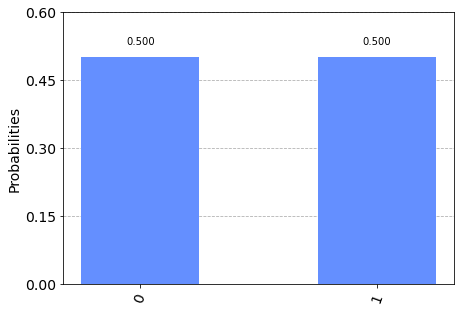

In [6]:
plot_histogram(result.get_counts())

Note that as long as your circuit does not make any measurements, you can also use the Statevector method <code>evolve()</code> to obtain the output statevector. This method takes in a QuantumCircuit object as a parameter and then returns the output state as a Statevector. 

In [7]:
# quantum circuit from above
circ = QuantumCircuit(1) 
circ.h(0)                
circ.z(0)
circ.x(0)
# construct a statevector object to be state |0>
state = Statevector([1, 0])
# use evolve() to determine the final state
output_state = state.evolve(circ)
output_state.draw(output='latex')

<IPython.core.display.Latex object>

### Multi-qubit Circuits

Below is an example of two qubit circuit that peforms controlled-not gate:

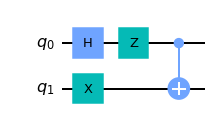

In [8]:
circ = QuantumCircuit(2)  
circ.x(1)
circ.h(0)
circ.z(0)
circ.cx(0, 1)      # parameters: (control qubit index, target qubit index)
circ.draw('mpl')

In [9]:
result = qis401.simulate_circuit(circ)
result.get_statevector().draw(output='latex')

<IPython.core.display.Latex object>

Notice that based on the bra-ket calculations we've done in class, we should expect to obtain the following final state (where we first apply the $H$ gate on $q_0$, then $X$ gate on $q_1$, then $Z$ gate on $q_0$, and then $CX$ gate with $q_0$ and $q_1$ as the control and target, respectively):

$ |00|\rangle 
\rightarrow \frac{\sqrt{2}}{2}|00\rangle + \frac{\sqrt{2}}{2}|10\rangle 
\rightarrow \frac{\sqrt{2}}{2}|01\rangle + \frac{\sqrt{2}}{2}|11\rangle 
\rightarrow \frac{\sqrt{2}}{2}|01\rangle - \frac{\sqrt{2}}{2}|11\rangle 
\rightarrow \frac{\sqrt{2}}{2}|01\rangle - \frac{\sqrt{2}}{2}|10\rangle $

In particular, in the output from Qiskit, the negative sign seems to be on the wrong basis state!

Thus note (<b>important</b>!) that Qiskit enumerates its kets/basis states in *reverse order*, i.e., the right-most digit corresponds to the first qubit, instead of the left-most digit (this is discussed in the blue box in the [Qiskit getting started page](https://qiskit.org/documentation/tutorials/circuits/1_getting_started_with_qiskit.html).) 

### Register Objects and Measurement

Instead of referring to qubits using indices, it is often more useful to construct "quantum register" objects, which allow us designate and interact with each qubit in an object oriented manner. Register objects are then passed into the circuit constructor to initialize the circuit. To add quantum gates to the circuit, we then pass in the corresponding register object to the gate function. 

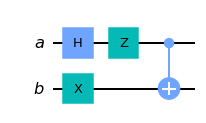

In [10]:
a_reg = QuantumRegister(1, "a")      # 1 indicates the register contains 1 qubit, second parameter is label
b_reg = QuantumRegister(1, "b")
circ = QuantumCircuit(a_reg, b_reg)  # pass in register objects to construct the circuit 
circ.x(b_reg)                        # pass in register objects to gate functoins to design the circuit
circ.h(a_reg)                       
circ.z(a_reg)
circ.cx(a_reg, b_reg)    
circ.draw('mpl')

When we want the circuit to measure qubits, we need add objects for classical registers. We can then use the <code>measure()</code> method to peform a measurement on a qubit and store the result in a classical register. 

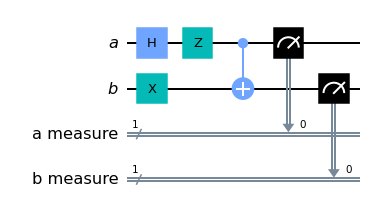

In [11]:
# initailize registers and circuit objects
a_reg = QuantumRegister(1, "a")     
b_reg = QuantumRegister(1, "b")
ameas_reg = ClassicalRegister(1, "a measure")
bmeas_reg = ClassicalRegister(1, "b measure")
circ = QuantumCircuit(a_reg, b_reg, ameas_reg, bmeas_reg)  

# construct the circuit
circ.x(b_reg)                      
circ.h(a_reg)                       
circ.z(a_reg)
circ.cx(a_reg, b_reg)  
circ.measure(a_reg, ameas_reg)  # parameters (Quantum Register, Classical Register storing result)
circ.measure(b_reg, bmeas_reg)

# display circuit
circ.draw('mpl')

As discussed earlier, notice that if we try to use the <code>evolve()</code> on the above circut, we get an error since the circuit makes a measurement. 

In [13]:
state = Statevector([1, 0, 0, 0])
output_state = state.evolve(circ)
output_state.draw(output='latex')

QiskitError: 'Cannot apply instruction with classical bits: measure'

Finally, if we want the circuit to make to apply a quantum gate conditioned on the result of a measurement, we can use <code>c_if()</code> method (which is a method of the <code>InstructionSet</code> objects that are returned whenever we add a gate to the circuit). The first parameter of <code>c_if()</code> is the classical register that determines whether the gate gets executed, and the second parameter determines the value the classical register must have in order to trigger the gate.

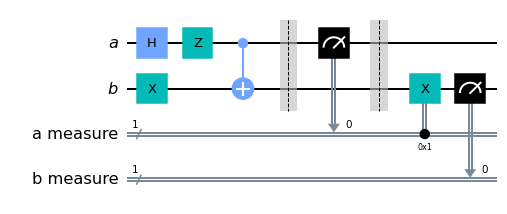

In [14]:
# initailize registers and circuit objects
a_reg = QuantumRegister(1, "a")     
b_reg = QuantumRegister(1, "b")
ameas_reg = ClassicalRegister(1, "a measure")
bmeas_reg = ClassicalRegister(1, "b measure")
circ = QuantumCircuit(a_reg, b_reg, ameas_reg, bmeas_reg)  

# gates before measurement of a
circ.x(b_reg)                      
circ.h(a_reg)                       
circ.z(a_reg)
circ.cx(a_reg, b_reg) 
circ.barrier()         # barrier() is used to organize circuit into segments (does not affect outcome)
    
# measure a
circ.measure(a_reg, ameas_reg)  # parameters: (Quantum Register, Classical Register storing result)
circ.barrier()

# execute X gate on b if result of a measurement = 1, and then measure b
xgate = circ.x(b_reg)
xgate.c_if(ameas_reg, 1)           
circ.measure(b_reg, bmeas_reg)

# display circuit
circ.draw('mpl')

## Quantum Circuits as NumPy Matrices

In addition to using Qiskit to create and simulate quantum circuits, we will also implement quantum algorithms in their vector/matrix form using NumPy. The below cells show how to construct a vector/matrix that corresponds to a state/quantum gate in a quantum circuit.

In [16]:
# creating matrix for Hadamard gate
h = np.array([[1/cmath.sqrt(2), 1/cmath.sqrt(2)], [1/cmath.sqrt(2), -1/cmath.sqrt(2)]])
print(h)

[[ 0.70710678+0.j  0.70710678+0.j]
 [ 0.70710678+0.j -0.70710678+0.j]]


In [17]:
# applying Hadamard to starting state |0>
start = np.array([1, 0])
output = h @ start       # @ operator peforms a matrix multiplication
print(output)

[0.70710678+0.j 0.70710678+0.j]


Note that we can still feed the final NumPy vector in the Statevector() constructor if we want to display the state in bra-ket notation. 

In [18]:
# passing in NumPy array to qiskit StateVector object to display final state as bra-ket
output_sv = Statevector(output) 
output_sv.draw('latex')

<IPython.core.display.Latex object>

For a 2-qubit example, recall the corresponding matrix operations for quantum circuit from Lecture 6: 
<div align="center">
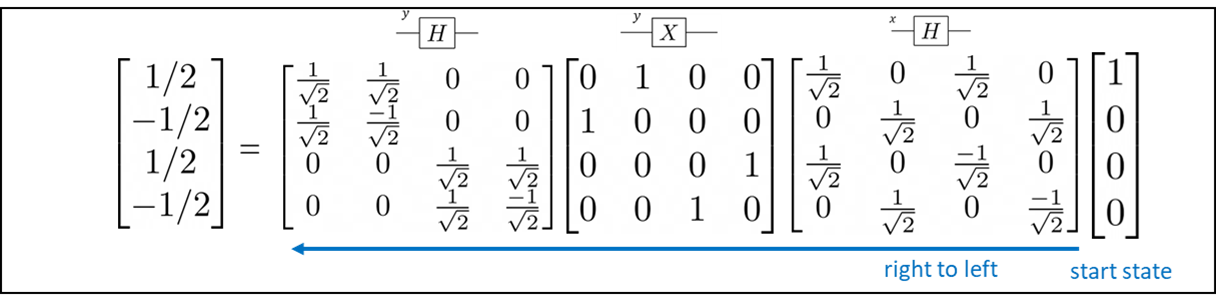
</div>

In order to create 2-qubit quantum gates, we will need to use the NumPy <code>kron()</code>, which calculates the Kronecker/tensor product of two matrices (exactly as we saw in the slides for Lecture 6). 

In [19]:
start = np.array([1, 0, 0, 0])
h = np.array([[1/cmath.sqrt(2), 1/cmath.sqrt(2)], [1/cmath.sqrt(2), -1/cmath.sqrt(2)]])
x =  np.array([[0, 1], [1, 0]])
i =  np.array([[1, 0], [0, 1]])

gate1 = np.kron(h, i)
gate2 = np.kron(i, x)
gate3 = np.kron(i, h)

output = gate3 @ gate2 @ gate1 @ start
output_sv = Statevector(output)
output_sv.draw('latex')

<IPython.core.display.Latex object>

Notice that the basis state labels do now align with conventions we've seen in class (since our matrices are using the standard enumeration). 

## Practice Problems

#### Problem 1: Qiskit Circuits for Bell States

Recall the following entangled quantum state, known as the EPR pair:

$$ \frac{|00\rangle + |11\rangle}{\sqrt{2}}.$$

More generally, the EPR pair is one four possible entangled quantum states known as the <i>Bell states</i>, denoted $\beta_{00}, \beta_{01}, \beta_{10}, \beta_{11}$, where the EPR pair corresponds to the Bell state $\beta_{00}$. The remaining three Bell states are defined as follows:

$$ \beta_{01} = \frac{|01\rangle + |10\rangle}{\sqrt{2}}$$
$$ \beta_{10} = \frac{|00\rangle - |11\rangle}{\sqrt{2}}$$
$$ \beta_{11} = \frac{|01\rangle - |10\rangle}{\sqrt{2}}.$$

Use Qiskit to design three separate 2-qubit circuits that transform the starting state $|00\rangle$ to the Bell states $\beta_{01}, \beta_{10}$, and $\beta_{11}$ (i.e. one circuit for each Bell state). Have your code display each circuit and display the final state in bra-ket notation to verify each circuit reaches the desired Bell state. 

In [ ]:
# YOUR CODE GOES HERE (create additional cells as needed)

#### Problem 2: NumPy Matrices for Bell States

Repeat the same exercise in Problem 1, but now implement your circuit with NumPy matrices. Again test to make sure your circuit is correct by displaying the final state in bra-ket notation.  

In [ ]:
# YOUR CODE GOES HERE (create additional cells as needed)